In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from sasmodels.data import empty_data1D, Data1D
from sasmodels.core import load_model
from sasmodels.direct_model import DirectModel

from sasformer.data import IqTransformer, SASDataModule
from sasformer.model import SASPerceiverIOModel

In [3]:
def generate_Iq(q: np.ndarray, model_name: str, params: dict, resolution: float = 0.05):
    data = empty_data1D(q, resolution=resolution)
    model = load_model(model_name)
    model_fn = DirectModel(data, model)
    return model_fn(**params)

In [4]:
data_dir = "../data/sas-55m-20k/"
checkpoint_path = "../checkpoints/final.ckpt"

#### Generate $I(q)$ using `sasmodels`

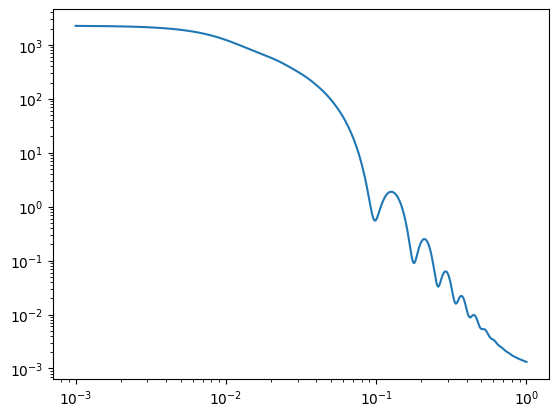

In [5]:
# load q values
q = np.load(f"{data_dir}q_values.npy")

# specify model and generate I(q)
model_name = "cylinder"
model_params = {"length": 500, "radius": 40}
Iq = generate_Iq(q, model_name, model_params)[None, :]

plt.loglog(q, Iq[0])
plt.show()

#### Load and initialize model

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sasformer = SASPerceiverIOModel.load_from_checkpoint(checkpoint_path=checkpoint_path)#.to(device)
sasformer.eval()
print(sasformer.hparams, '\n')

"batch_size":                     1843
"clf_weight":                     1.0
"enc_cross_attention_dropout":    0.05
"enc_cross_attn_widening_factor": 1
"enc_dropout":                    0.05
"enc_num_blocks":                 1
"enc_num_cross_attn_heads":       4
"enc_num_self_attn_heads":        4
"enc_num_self_attn_per_block":    12
"enc_self_attention_dropout":     0.05
"enc_self_attn_widening_factor":  1
"input_transformer":              IqTransformer()
"latent_dim":                     1024
"lr":                             0.00072
"model_dec_attn_dropout":         0.45
"model_dec_dropout":              0.45
"model_dec_num_heads":            4
"model_dec_qk_out_dim":           256
"model_dec_widening_factor":      3
"n_bins":                         256
"num_classes":                    55
"num_latents":                    48
"num_reg_outputs":                219
"param_dec_attn_dropout":         0.05
"param_dec_dropout":              0.05
"param_dec_num_heads":            2
"param

#### Load data module

In [7]:
datamodule = SASDataModule(data_dir=data_dir,
    n_bins=sasformer.hparams['n_bins'],
    batch_size=1,
    val_size=0.25,
    seed=256
)
datamodule.setup()

# mapping for clf predictions to scattering model
with open("../data/label_to_model.pkl", "rb") as f:
    label_to_model = pickle.load(f)

# mapping for reg predictions to model parameters
with open("../data/model_to_param_idxs.pkl", "rb") as f:
    model_to_param_idxs = pickle.load(f)

/home/by256/anaconda3/envs/sasformer/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


#### Predict scattering model and parameters

In [8]:
# quotient transform
Iq_qt = torch.LongTensor(datamodule.input_transformer.transform(Iq))

# predict
with torch.no_grad():
    y_pred_clf, y_pred_reg = sasformer(Iq_qt)
y_pred_reg = y_pred_reg.detach().cpu().numpy()

# classification prediction
pred_model = label_to_model[y_pred_clf.argmax().item()]
print(f"Predicted model: {pred_model}")

# regression predictions
model_param_idxs = model_to_param_idxs[pred_model]
pred_params = [datamodule.target_transformer.inverse_transform(y_pred_reg)[0][i] for i in model_param_idxs]
print(f"Predicted parameters: {pred_params}")

Predicted model: cylinder
Predicted parameters: [519.67664, 35.122982]


The predicted model matches the model we used to generate the data and the predicted parameters are roughly close.